In [38]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [40]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [41]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits. First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [42]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [43]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [44]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [45]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
 18/235 [=>............................] - ETA: 1s - loss: 0.6688

2021-09-25 18:30:23.621016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 2s 7ms/step - loss: 0.3839 - val_loss: 0.1865
Epoch 2/50
 10/235 [>.............................] - ETA: 1s - loss: 0.1866

2021-09-25 18:30:25.101169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 6ms/step - loss: 0.1771 - val_loss: 0.1520
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1482 - val_loss: 0.1331
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1311 - val_loss: 0.1212
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1203 - val_loss: 0.1126
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1120 - val_loss: 0.1062
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1062 - val_loss: 0.1018
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1022 - val_loss: 0.0987
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0996 - val_loss: 0.0965
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0976 - val_loss: 0.0951
Epoch 11/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0961 - val_loss: 0.0943
Epoch 12/

In [46]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

2021-09-25 18:31:43.591290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-25 18:31:43.899548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


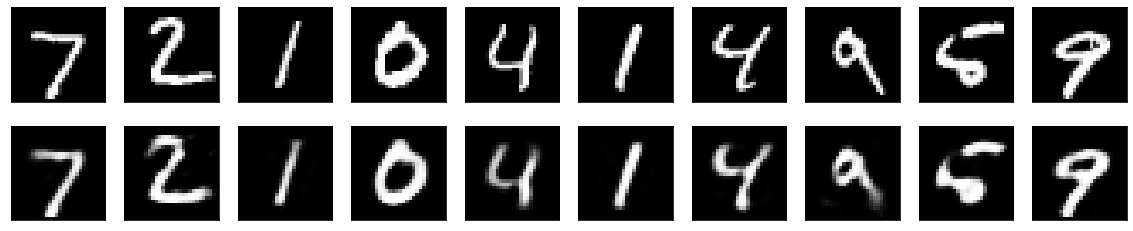

8.671791

In [47]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt
def visualization(x_test, decoded_imgs, n=10):
    #n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return plt
visualization(x_test, decoded_imgs).show()
encoded_imgs.mean()

the representations above were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer: Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

In [48]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [49]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

Here's a visualization of our new results:

In [50]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
 19/235 [=>............................] - ETA: 1s - loss: 0.6722

2021-09-25 18:32:15.107783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 2s 7ms/step - loss: 0.3955 - val_loss: 0.1982
Epoch 2/100
 10/235 [>.............................] - ETA: 1s - loss: 0.2001

2021-09-25 18:32:16.591399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 6ms/step - loss: 0.1875 - val_loss: 0.1609
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1567 - val_loss: 0.1432
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1415 - val_loss: 0.1317
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1308 - val_loss: 0.1235
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1231 - val_loss: 0.1176
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1177 - val_loss: 0.1137
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1136 - val_loss: 0.1106
Epoch 9/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1110 - val_loss: 0.1083
Epoch 10/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1089 - val_loss: 0.1068
Epoch 11/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1077 - val_loss: 0.1057


2021-09-25 18:34:48.260543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-25 18:34:48.564401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


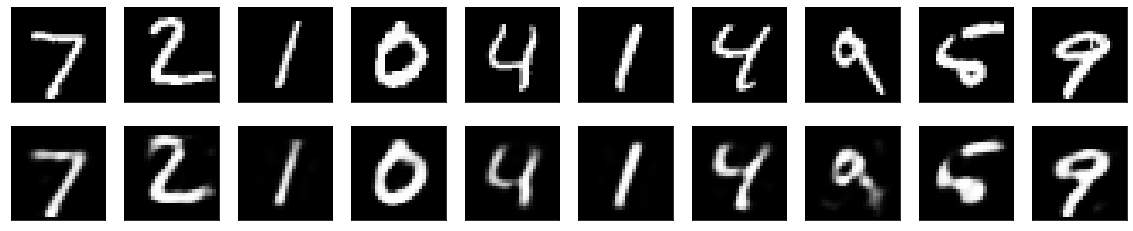

1.2787602

In [51]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
visualization(x_test, decoded_imgs).show()
encoded_imgs.mean()

In [52]:
# Deep autoencoder
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
 14/235 [>.............................] - ETA: 1s - loss: 0.6716

2021-09-25 18:34:59.513505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 9ms/step - loss: 0.3414 - val_loss: 0.1637
Epoch 2/100
  1/235 [..............................] - ETA: 1s - loss: 0.1667

2021-09-25 18:35:01.616022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 2s 9ms/step - loss: 0.1555 - val_loss: 0.1362
Epoch 3/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1337 - val_loss: 0.1222
Epoch 4/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1221 - val_loss: 0.1160
Epoch 5/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1155 - val_loss: 0.1100
Epoch 6/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1105 - val_loss: 0.1059
Epoch 7/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1066 - val_loss: 0.1030
Epoch 8/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1030 - val_loss: 0.1002
Epoch 9/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1006 - val_loss: 0.0984
Epoch 10/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0987 - val_loss: 0.0966
Epoch 11/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0976 - val_loss: 0.0957


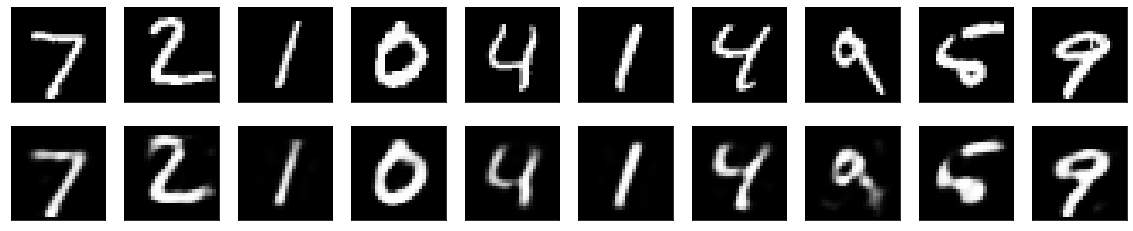

1.2787602

In [53]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
visualization(x_test, decoded_imgs).show()
encoded_imgs.mean()

Convolutional autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.
Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [54]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [55]:
#To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback. First, let's open up a terminal and start a TensorBoard server that will read logs stored at `/tmp/autoencoder/`. Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to `/tmp/autoencoder/`, which can be read by our TensorBoard server.

In [56]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

2021-09-25 18:54:49.410955: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-09-25 18:54:49.410968: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-09-25 18:54:49.411140: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/50
  1/469 [..............................] - ETA: 5:01 - loss: 0.6930

2021-09-25 18:54:49.968918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-25 18:54:50.095406: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-09-25 18:54:50.095415: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  9/469 [..............................] - ETA: 17s - loss: 0.6849

2021-09-25 18:54:50.205106: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-25 18:54:50.205914: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-09-25 18:54:50.206566: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/autoencoder/train/plugins/profile/2021_09_25_18_54_50
2021-09-25 18:54:50.207258: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/autoencoder/train/plugins/profile/2021_09_25_18_54_50/Toms-Air.trace.json.gz
2021-09-25 18:54:50.208153: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/autoencoder/train/plugins/profile/2021_09_25_18_54_50
2021-09-25 18:54:50.208287: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/autoencoder/train/plugins/profile/2021_09_25_18_54_50/Toms-Air.memory_profile

468/469 [============================>.] - ETA: 0s - loss: 0.3158

2021-09-25 18:55:03.186697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 15s 31ms/step - loss: 0.3153 - val_loss: 0.1483
Epoch 2/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1431 - val_loss: 0.1301
Epoch 3/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1288 - val_loss: 0.1215
Epoch 4/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1211 - val_loss: 0.1166
Epoch 5/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1162 - val_loss: 0.1127
Epoch 6/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1129 - val_loss: 0.1107
Epoch 7/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1107 - val_loss: 0.1084
Epoch 8/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1091 - val_loss: 0.1070
Epoch 9/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1079 - val_loss: 0.1058
Epoch 10/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1067 - val_los

The model converges to a loss of 0.09, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

In [57]:
decoded_imgs = autoencoder.predict(x_test)

2021-09-25 19:06:38.806184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


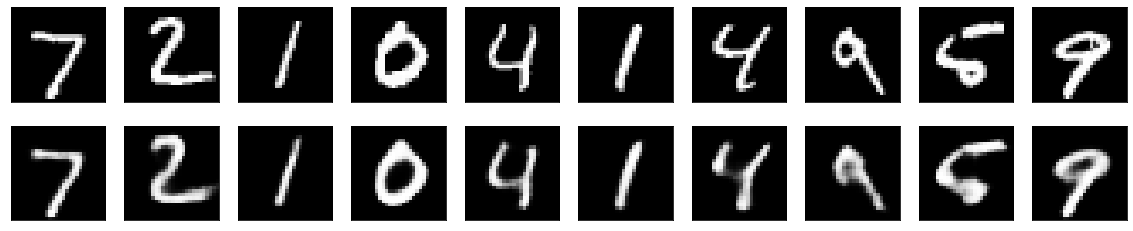

1.2787602

In [58]:
visualization(x_test, decoded_imgs).show()
encoded_imgs.mean()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

2021-09-25 19:06:53.911492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(10000, 4, 4, 8)


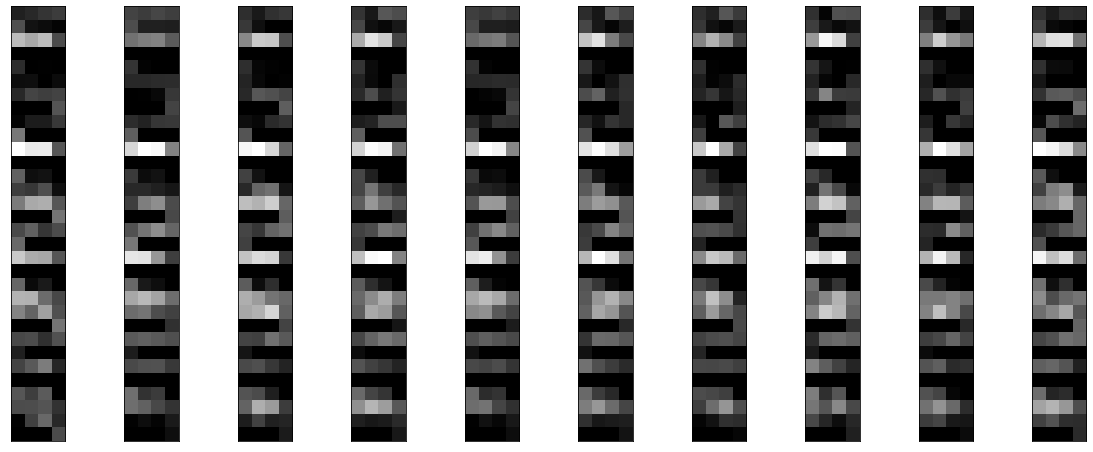

In [59]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
print(encoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Application to image denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images. Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1

In [60]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

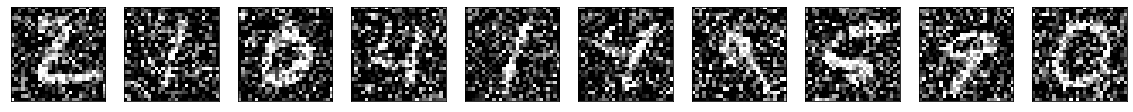

In [61]:
# The noisy image looks like the follows:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out. Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [62]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [63]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

2021-09-25 19:07:34.254068: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-09-25 19:07:34.254083: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-09-25 19:07:34.254232: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/100
  1/469 [..............................] - ETA: 4:01 - loss: 0.7207

2021-09-25 19:07:34.708660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-25 19:07:34.821417: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-09-25 19:07:34.821427: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-09-25 19:07:34.890048: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-25 19:07:34.890688: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-09-25 19:07:34.891210: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tb/train/plugins/profile/2021_09_25_19_07_34
2021-09-25 19:07:34.892463: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tb/train/plugins/profile/2021_09_25_19_07_34/Toms-Air.trace.json.gz
2021-09-25 19:07:34.893394: 

469/469 [==============================] - ETA: 0s - loss: 0.2638

2021-09-25 19:07:50.219763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 17s 36ms/step - loss: 0.2636 - val_loss: 0.1190
Epoch 2/100
469/469 [==============================] - 16s 35ms/step - loss: 0.1171 - val_loss: 0.1100
Epoch 3/100
469/469 [==============================] - 16s 35ms/step - loss: 0.1099 - val_loss: 0.1064
Epoch 4/100
469/469 [==============================] - 17s 35ms/step - loss: 0.1064 - val_loss: 0.1040
Epoch 5/100
469/469 [==============================] - 17s 35ms/step - loss: 0.1044 - val_loss: 0.1021
Epoch 6/100
469/469 [==============================] - 16s 35ms/step - loss: 0.1028 - val_loss: 0.1011
Epoch 7/100
469/469 [==============================] - 17s 35ms/step - loss: 0.1016 - val_loss: 0.0999
Epoch 8/100
469/469 [==============================] - 16s 35ms/step - loss: 0.1003 - val_loss: 0.0991
Epoch 9/100
469/469 [==============================] - 16s 35ms/step - loss: 0.0997 - val_loss: 0.0983
Epoch 10/100
469/469 [==============================] - 17s 35ms/step - loss: 0.0989 

2021-09-25 19:36:58.468644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


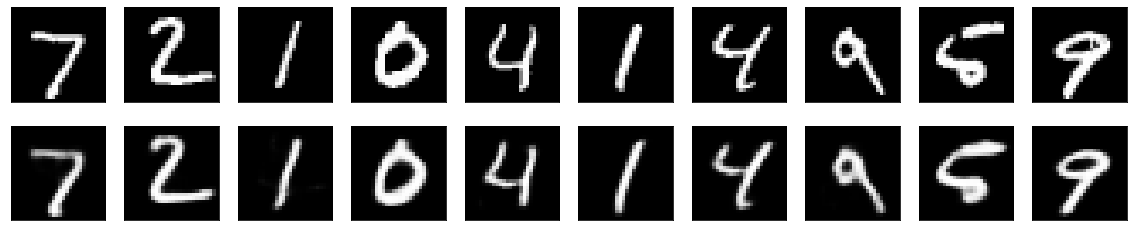

1.8012867

In [64]:
decoded_imgs = autoencoder.predict(x_test_noisy)
visualization(x_test, decoded_imgs).show()
encoded_imgs.mean()

Sequence-to-sequence autoencoder
If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence. We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

In [ ]:
""" timesteps = ...  # Length of your sequences
input_dim = ... 
latent_dim = ...

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = layers.LSTM(latent_dim)(inputs)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded) """


Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

Because a VAE is a more complex example, we have made the code available on Github as a standalone script. Here we will review step by step how the model is created.

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [25]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np

In [26]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [27]:
#We can use these parameters to sample new similar points from the latent space:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [28]:
#Finally, we can map these sampled latent points back to reconstructed inputs:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

What we've done so far allows us to instantiate 3 models:

    an end-to-end autoencoder mapping inputs to reconstructions
    an encoder mapping inputs to the latent space
    a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [29]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(lambda: vae_loss)
vae.compile(optimizer='adam')

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()